# Effect of compound kernels on GP fit

This notebook examines the incremental affect of adding more terms to the GP kernel expression, namely Squared Exponential, Matern $\frac{3}{2}$, and Periodic kernels.

There is the possibility of degeneracy between the various hyperparameters of the chosen kernels, especially the overlapping influences on input and output scale parameters ($\ell$ and $\eta$).

Four light curves taken from the ThunderKAT survey have been selected as test cases:
- `80_ra271.352_dec-29.642_MAXIJ1803`: 
- `1817_ra284.905_dec-8.658_J1858TraPDB`
- `428_ra236.530_dec-46.922_4U1543TraPDB`: evenly spaced, no obvious outliers, some correlated noise.
- `502_ra236.310_dec-47.644_4U1543TraPDB`



In [1]:
import math
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import graphviz as gv
import utility_functions as ufn

print(f"Running on PyMC v{pm.__version__}")
az.style.use("arviz-white")

RANDOM_SEED = 2023-10-10
rng = np.random.default_rng(RANDOM_SEED)

Running on PyMC v5.6.1


In [2]:
# File paths to CSVs of flux density observations.
csv_paths_list = list(Path('data_raw').iterdir())
csv_paths_list

[PosixPath('data_raw/428_ra236.530_dec-46.922_4U1543TraPDB_andersson.csv'),
 PosixPath('data_raw/502_ra236.310_dec-47.644_4U1543TraPDB_andersson.csv'),
 PosixPath('data_raw/1817_ra284.905_dec-8.658_J1858TraPDB_andersson.csv'),
 PosixPath('data_raw/80_ra271.352_dec-29.642_MAXIJ1803TraPDB_andersson.csv')]

# 428_ra236.530_dec-46.922_4U1543

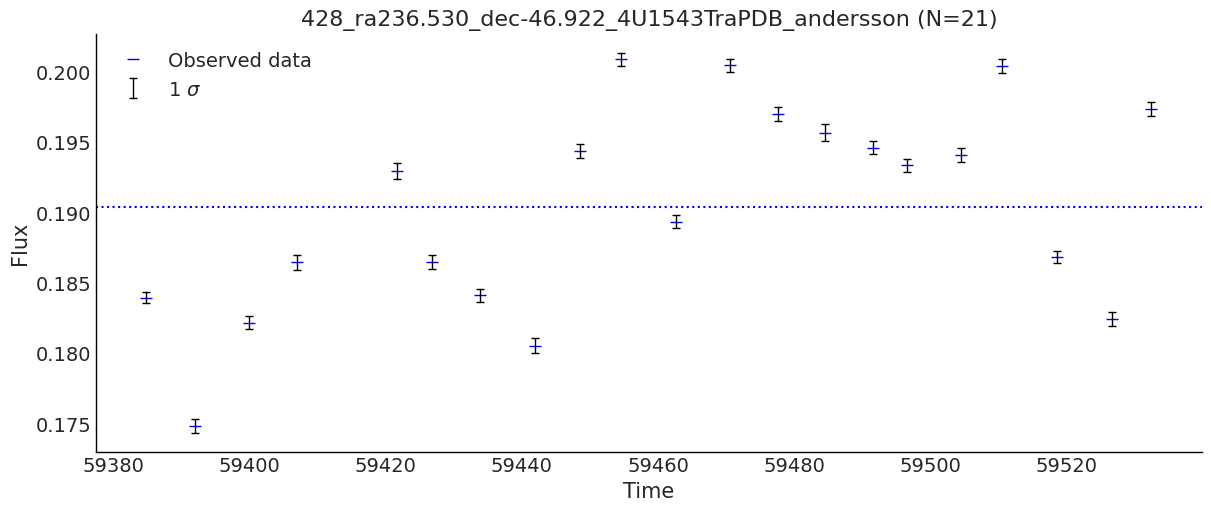

In [3]:
fpath = csv_paths_list[0]
ufn.plot_lc(fpath)

## SE Kernel only

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\textrm{SE}(\tau))$$

$$k_\textrm{SE}(\tau) = \eta^2_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{SE} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN},i} \sim \textrm{HalfNormal}(e_i^2)$$

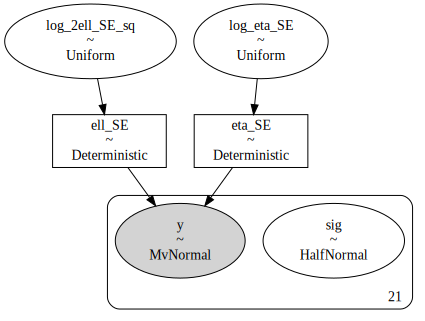

In [4]:
se_trace, se_dag = ufn.fit_se_gp(fpath, save_trace=True, overwrite_trace=False, rng_seed=rng);

dag_path = f'dags/{fpath.stem}_se_dag.dot'
with open(dag_path, 'w') as writehandle:
    writehandle.write(se_dag.source)

gv.Source(se_dag.source)

In [5]:
variable_names = ["log_2ell_SE_sq", "log_eta_SE", "ell_SE", "eta_SE"]
ufn.print_post_summary(fpath, variable_names)

median       mad    eti_16%    eti_84%  mcse_median  \
log_2ell_SE_sq   5.708939  0.071848   5.598054   5.808080     0.002324   
log_eta_SE      -1.980095  0.133245  -2.164196  -1.775397     0.003782   
ell_SE          12.279068  0.441453  11.616815  12.903084     0.014265   
eta_SE           0.138056  0.018314   0.114842   0.169416     0.000522   

                 ess_median     ess_tail     r_hat       mean        sd  
log_2ell_SE_sq  3751.110751  1980.167805  1.001401   5.702558  0.109079  
log_eta_SE      4178.916321  2846.672813  1.000353  -1.968846  0.196232  
ell_SE          3751.110751  1980.167805  1.001412  12.258045  0.662219  
eta_SE          4178.916321  2846.672813  1.000094   0.142401  0.029312

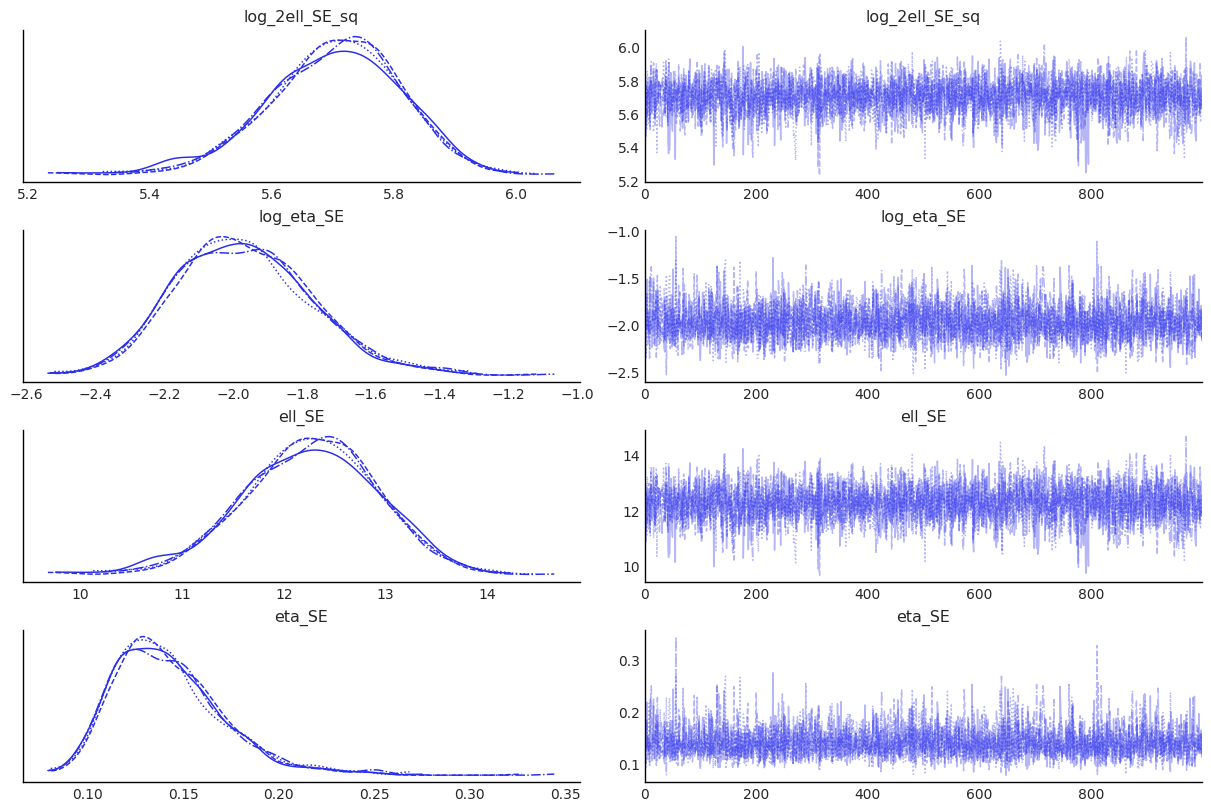

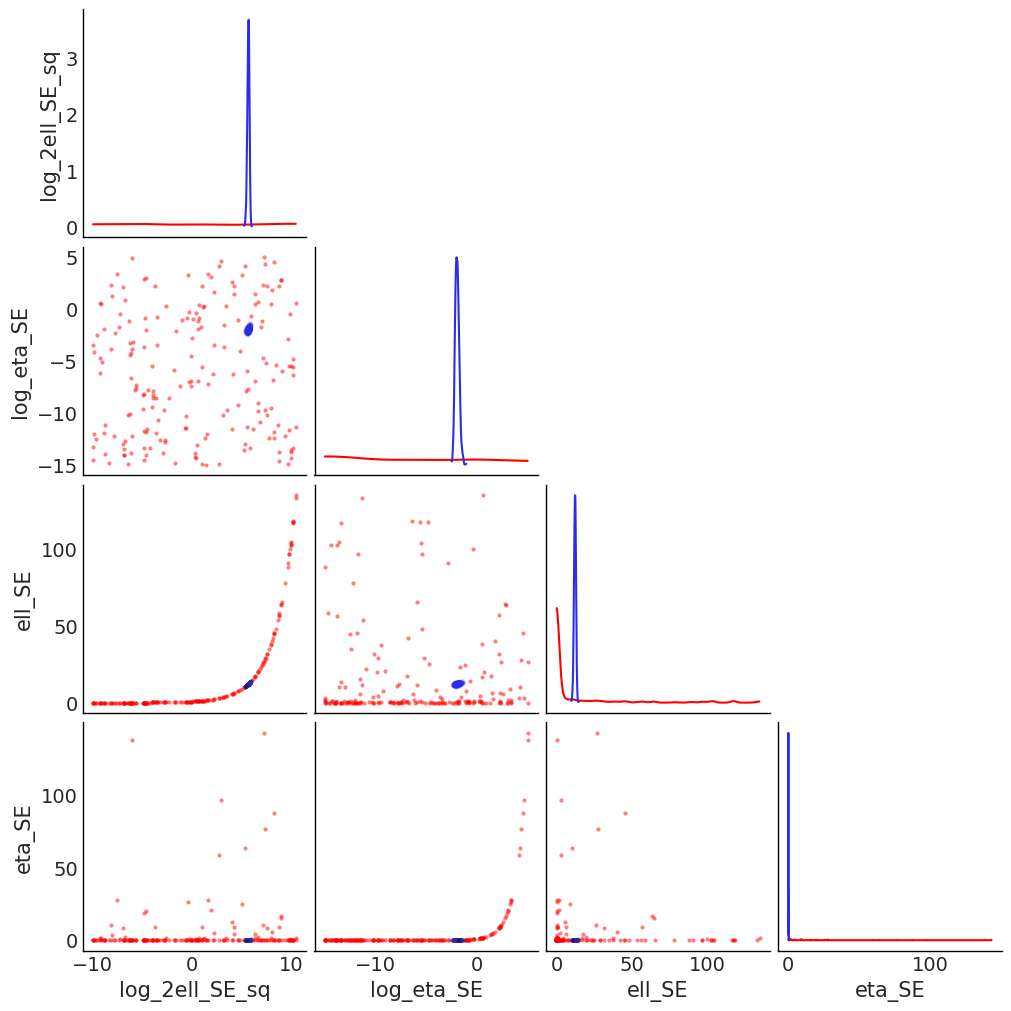

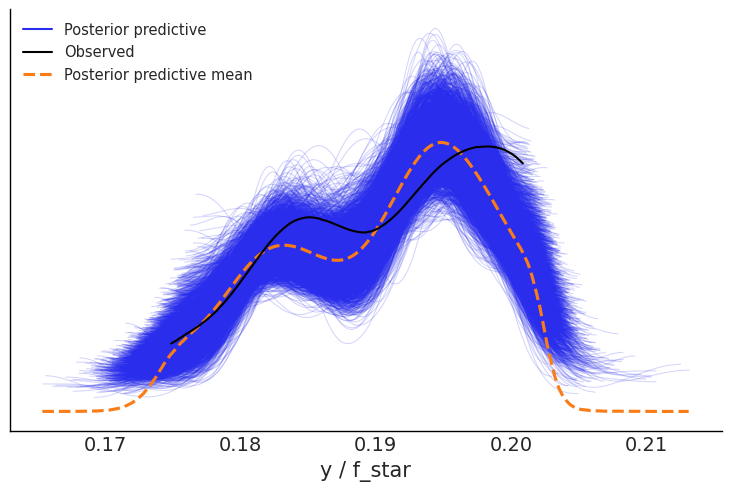

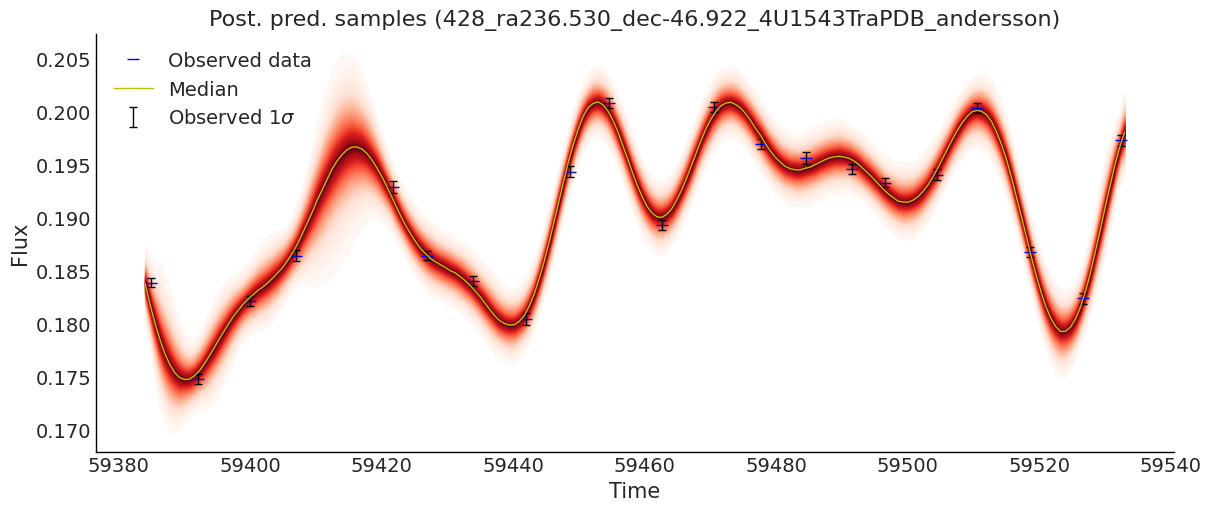

In [6]:
ufn.plot_traces(fpath, variable_names)
ufn.plot_priorpost_cnr(fpath, variable_names)
az.plot_ppc(se_trace, data_pairs={"y":"f_star"})
ufn.plot_postpred_samples(fpath)

## Matern $\frac{3}{2}$ Kernel only

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\textrm{M}(\tau))$$

$$k_\textrm{M}(\tau) =  \eta_\textrm{M}^2\left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{M} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

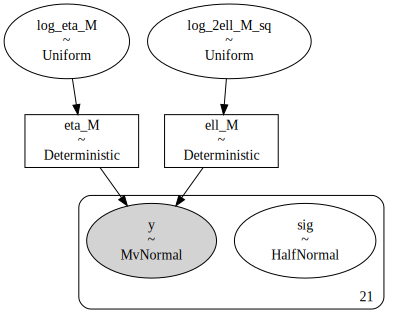

In [16]:
with pm.Model() as m32_gp_model:
    log_2ell_M_sq = pm.Uniform("log_2ell_M_sq", lower=-10, upper=math.log(2*t_range**2))
    ell_M = pm.Deterministic("ell_M", 0.5*math.sqrt(2) * pm.math.exp(0.5*log_2ell_M_sq))

    log_eta_M= pm.Uniform("log_eta_M", lower=-15, upper=5)
    eta_M = pm.Deterministic("eta_M", pm.math.exp(log_eta_M))

    cov_func = eta_M**2 * pm.gp.cov.Matern32(input_dim=1, ls=ell_M)
    
    gp = pm.gp.Marginal(cov_func=cov_func) # zero mean function 

    sig = pm.HalfNormal("sig", sigma=y_stderr) 
    cov_noise = pm.gp.cov.WhiteNoise(sigma=y_stderr)

    y_ = gp.marginal_likelihood(
        "y", 
        X=t.reshape(-1,1), 
        y=y.reshape(-1,1).flatten(), 
        sigma=cov_noise
    ) 

pm.model_to_graphviz(m32_gp_model)

Sampling: [log_2ell_M_sq, log_eta_M, sig, y]


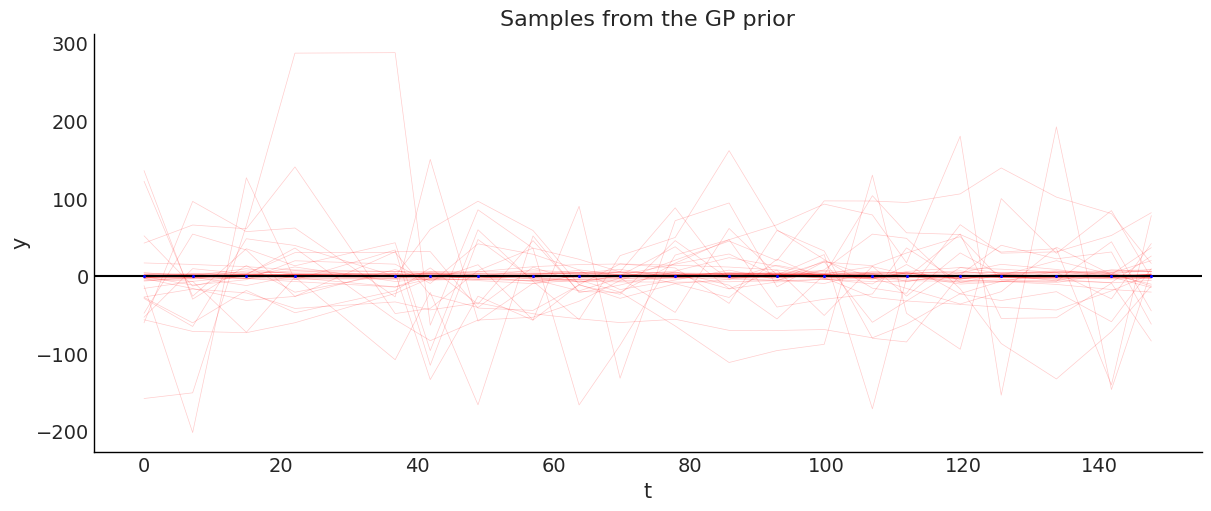

In [17]:
with m32_gp_model:
    m32_gp_trace = pm.sample_prior_predictive(samples=N_PPC, random_seed=rng)
    
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)

for prior_pred in m32_gp_trace.prior_predictive.y.to_numpy()[0]:
    ax.plot(t, prior_pred, lw=0.5, alpha=0.2, color="red")

ax.scatter(x=t, y=y, s=1.5, c="blue", zorder=10)
ax.axhline(0, color="black")
ax.set_title("Samples from the GP prior")
ax.set_ylabel("y")
ax.set_xlabel("t");

In [18]:
with m32_gp_model:
    m32_gp_trace.extend(
        pm.sample(
            draws=N_DRAWS, 
            tune=N_TUNE, 
            chains=4,
            cores=4, 
            random_seed=rng
        )       
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_2ell_M_sq, log_eta_M, sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


In [19]:
variable_names = ["log_2ell_M_sq", "log_eta_M", "ell_M", "eta_M"]
az.summary(m32_gp_trace, stat_focus="median", fmt="wide", var_names=variable_names, round_to="none", kind="all")

median        mad     eti_3%     eti_97%  mcse_median  \
log_2ell_M_sq   9.833182   0.370721   8.848289   10.617252     0.014078   
log_eta_M      -1.712483   0.243083  -2.326430   -1.072472     0.011144   
ell_M          96.545788  17.548717  59.001984  142.886734     0.679986   
eta_M           0.180417   0.042961   0.097644    0.342162     0.002011   

                ess_median     ess_tail     r_hat  
log_2ell_M_sq  2550.679246  1021.630258  1.003224  
log_eta_M      2207.795201  1663.363218  1.002422  
ell_M          2550.679246  1021.630258  1.003224  
eta_M          2207.795201  1663.363218  1.002422

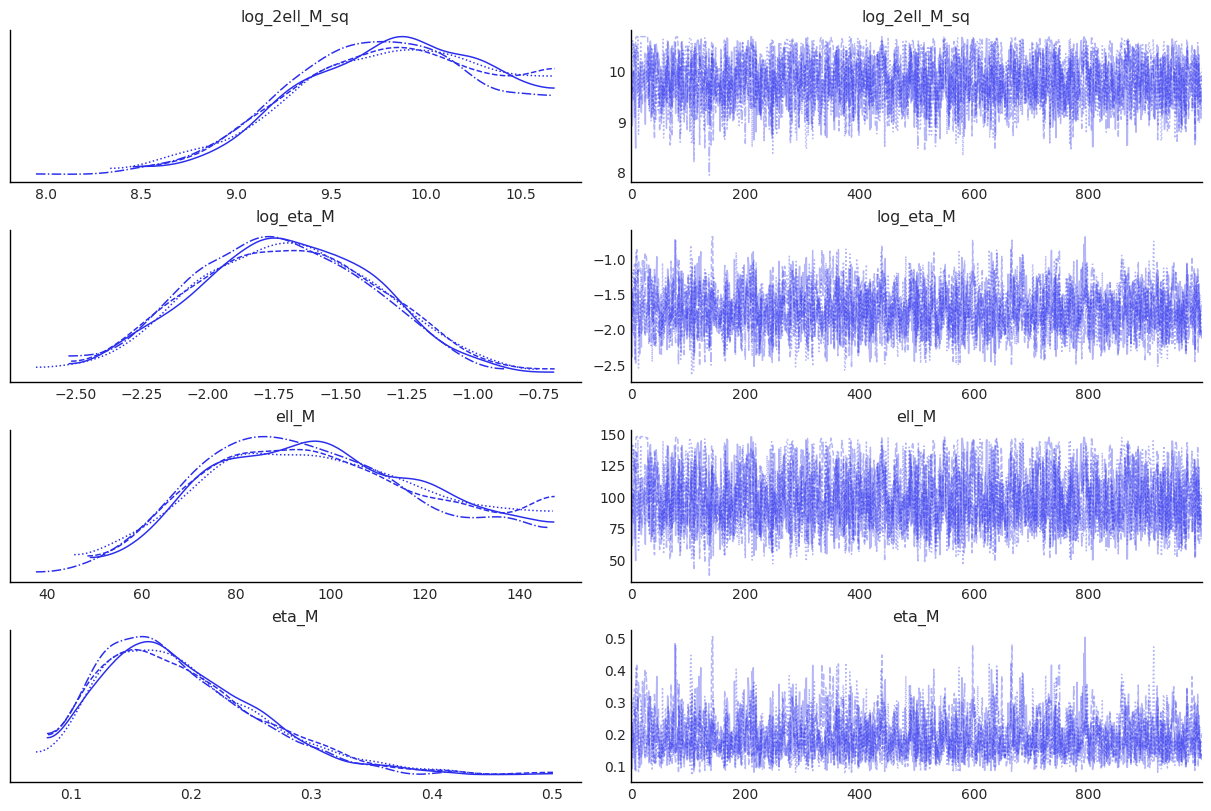

In [20]:
az.plot_trace(m32_gp_trace, var_names=variable_names, combined=False);

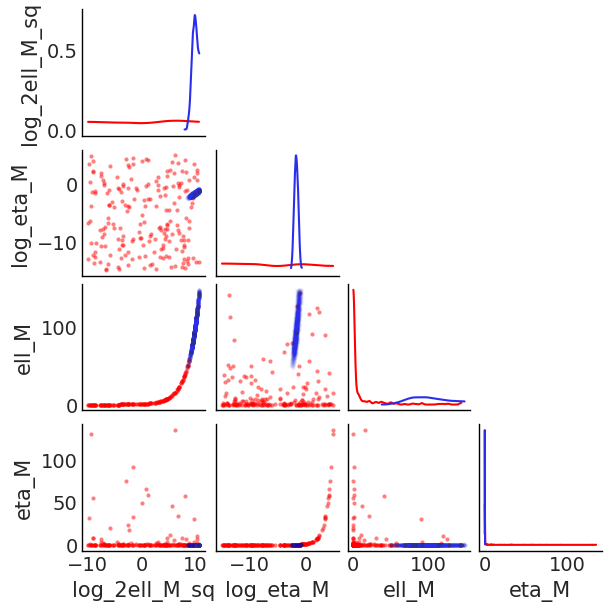

In [21]:
ax_list = az.plot_pair(
    m32_gp_trace, 
    group="prior", 
    var_names=variable_names,
    marginals=True, 
    figsize=(6,6), 
    kind=["scatter"],
    marginal_kwargs={"color":"red"},
    scatter_kwargs={"alpha":0.5, "color":"red"}
)

az.plot_pair(
    m32_gp_trace, 
    group="posterior",
    var_names=variable_names,
    marginals=True, 
    kind=["scatter"], 
    ax=ax_list, 
    scatter_kwargs={"alpha":0.01}
);

In [22]:
t_new = np.linspace(
    start=np.floor(t.min()), 
    stop=np.ceil(t.max()), 
    num = N_NEW
).reshape(-1,1)

with m32_gp_model:
    f_star = gp.conditional(name="f_star", Xnew=t_new, jitter=1e-6, pred_noise=False) 

In [23]:
with m32_gp_model:
    m32_gp_trace.extend(
        pm.sample_posterior_predictive(
            m32_gp_trace.posterior,  
            var_names=["f_star"], 
            random_seed=rng
        )
    )

Sampling: [f_star]


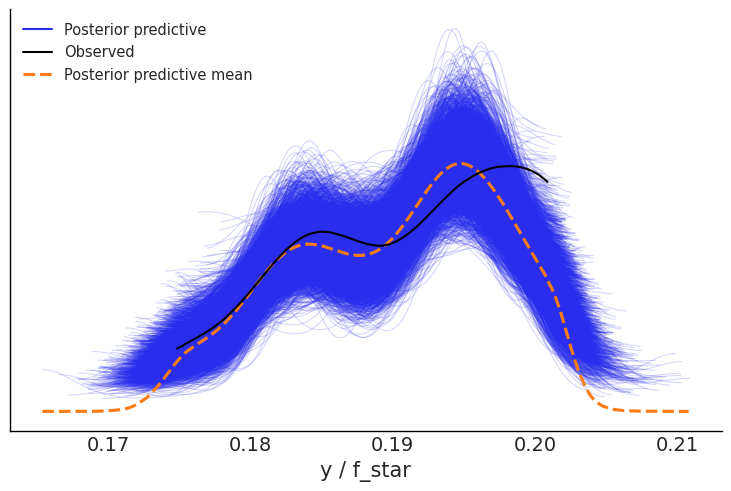

In [24]:
az.plot_ppc(m32_gp_trace, data_pairs={"y":"f_star"});

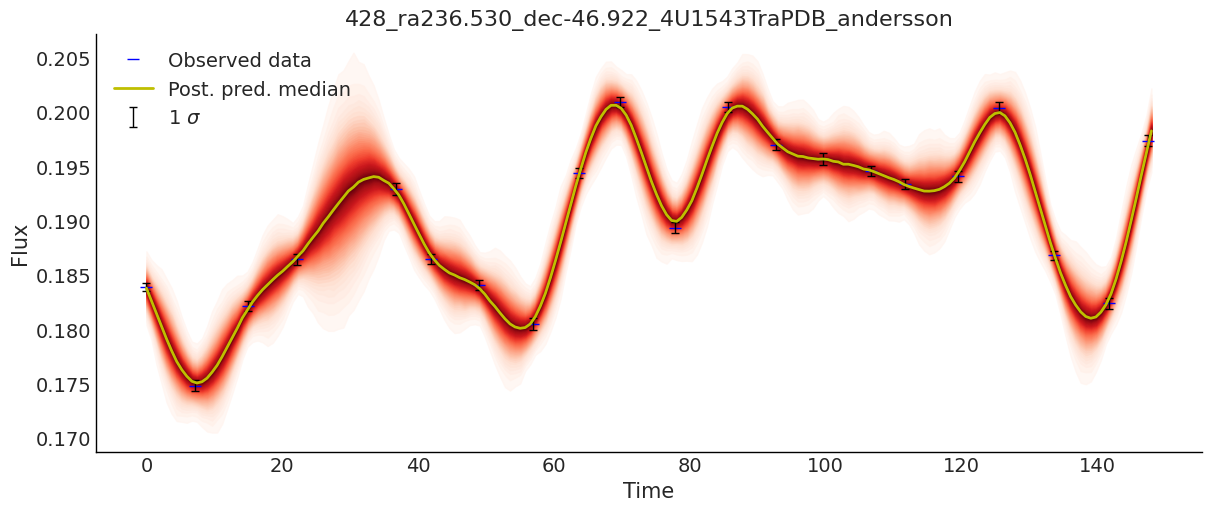

In [25]:
y_postpred = az.extract(m32_gp_trace.posterior_predictive, var_names=["f_star"])
y_postpred_median = y_postpred.median(dim="sample")

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plt.plot(t, y, "_b", ms=8, alpha=1, label="Observed data")
plt.errorbar(x=t, y=y, yerr=y_stderr, fmt="none", ecolor="k", elinewidth=1, capsize=3, label=r"1 $\sigma$")
plot_gp_dist(
    ax=ax, 
    samples=y_postpred.transpose("sample", ...),
    x=t_new,
    plot_samples=False
)
plt.plot(t_new.flatten(), y_postpred_median, "y", linewidth=2, label="Post. pred. median")
plt.title(f"{fpath.stem}")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend();

## SE + Matern $\frac{3}{2}$ additive kernel

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\textrm{SE+M}(\tau))$$

$$k_\textrm{SE+M}(\tau) = \eta^2_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\} + \eta^2_\textrm{M}\left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{SE} \sim \mathcal{U}[-15, 5]$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{M} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

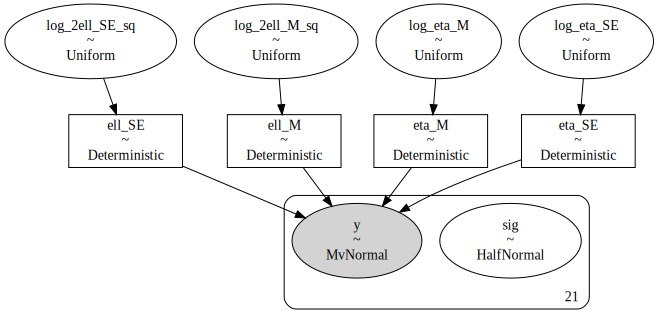

In [26]:
with pm.Model() as sem_gp_model:
    log_2ell_SE_sq = pm.Uniform("log_2ell_SE_sq", lower=-10, upper=math.log(2*t_range**2))
    ell_SE = pm.Deterministic("ell_SE", 0.5*math.sqrt(2) * pm.math.exp(0.5*log_2ell_SE_sq))

    log_eta_SE= pm.Uniform("log_eta_SE", lower=-15, upper=5)
    eta_SE = pm.Deterministic("eta_SE", pm.math.exp(log_eta_SE))

    log_2ell_M_sq = pm.Uniform("log_2ell_M_sq", lower=-10, upper=math.log(2*t_range**2))
    ell_M = pm.Deterministic("ell_M", 0.5*math.sqrt(2) * pm.math.exp(0.5*log_2ell_M_sq))

    log_eta_M= pm.Uniform("log_eta_M", lower=-15, upper=5)
    eta_M = pm.Deterministic("eta_M", pm.math.exp(log_eta_M))

    cov_func = eta_SE**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell_SE) + eta_M**2 * pm.gp.cov.Matern32(input_dim=1, ls=ell_M)
    
    gp = pm.gp.Marginal(cov_func=cov_func) # zero mean function 

    sig = pm.HalfNormal("sig", sigma=y_stderr) 
    cov_noise = pm.gp.cov.WhiteNoise(sigma=y_stderr)

    y_ = gp.marginal_likelihood(
        "y", 
        X=t.reshape(-1,1), 
        y=y.reshape(-1,1).flatten(), 
        sigma=cov_noise
    ) 

pm.model_to_graphviz(sem_gp_model)

Sampling: [log_2ell_M_sq, log_2ell_SE_sq, log_eta_M, log_eta_SE, sig, y]


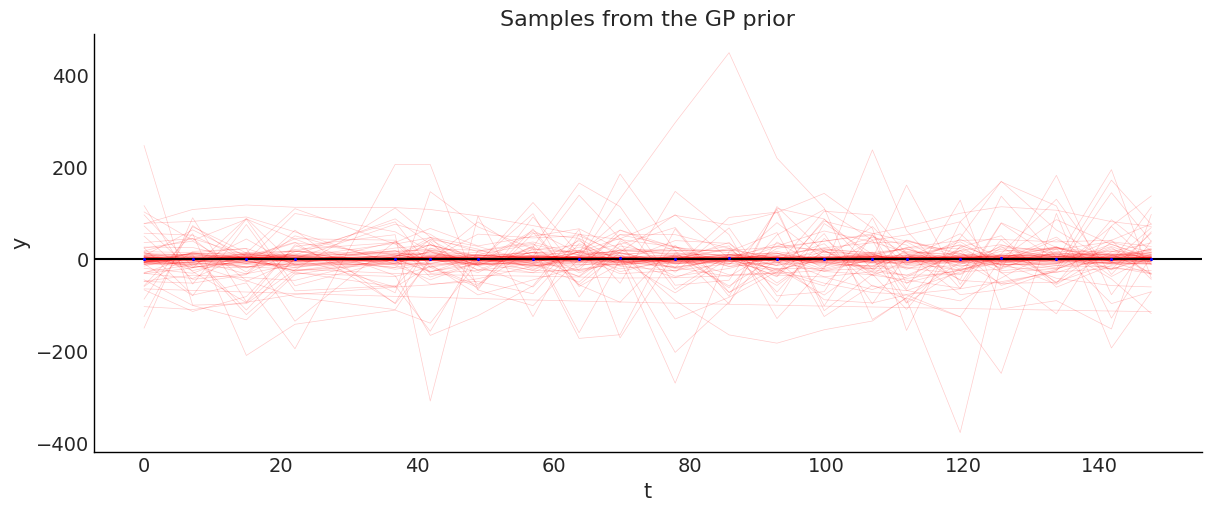

In [27]:
with sem_gp_model:
    sem_gp_trace = pm.sample_prior_predictive(samples=N_PPC, random_seed=rng)
    
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)

for prior_pred in sem_gp_trace.prior_predictive.y.to_numpy()[0]:
    ax.plot(t, prior_pred, lw=0.5, alpha=0.2, color="red")

ax.scatter(x=t, y=y, s=1.5, c="blue", zorder=10)
ax.axhline(0, color="black")
ax.set_title("Samples from the GP prior")
ax.set_ylabel("y")
ax.set_xlabel("t");

In [28]:
with sem_gp_model:
    sem_gp_trace.extend(
        pm.sample(
            draws=N_DRAWS, 
            tune=N_TUNE, 
            chains=4,
            cores=4, 
            random_seed=rng
        )       
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_2ell_SE_sq, log_eta_SE, log_2ell_M_sq, log_eta_M, sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 125 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


In [29]:
variable_names = ["log_2ell_SE_sq", "log_2ell_M_sq", "log_eta_SE", "log_eta_M"]
az.summary(sem_gp_trace, stat_focus="median", fmt="wide", var_names=variable_names, round_to="none", kind="all")

median       mad     eti_3%    eti_97%  mcse_median  \
log_2ell_SE_sq  10.263101  0.322559  -8.492586  10.660030     0.180364   
log_2ell_M_sq   -0.341257  5.125357  -9.371967  10.650487     2.324801   
log_eta_SE      -2.226478  0.420551 -11.373800  -1.216780     0.162652   
log_eta_M       -5.050394  0.209136  -5.420268  -1.466805     0.095301   

                ess_median   ess_tail     r_hat  
log_2ell_SE_sq   15.458590  47.037704  1.314557  
log_2ell_M_sq    15.154789  40.396499  1.312883  
log_eta_SE       15.887080  50.477108  1.314234  
log_eta_M        14.634781  46.517166  1.336376

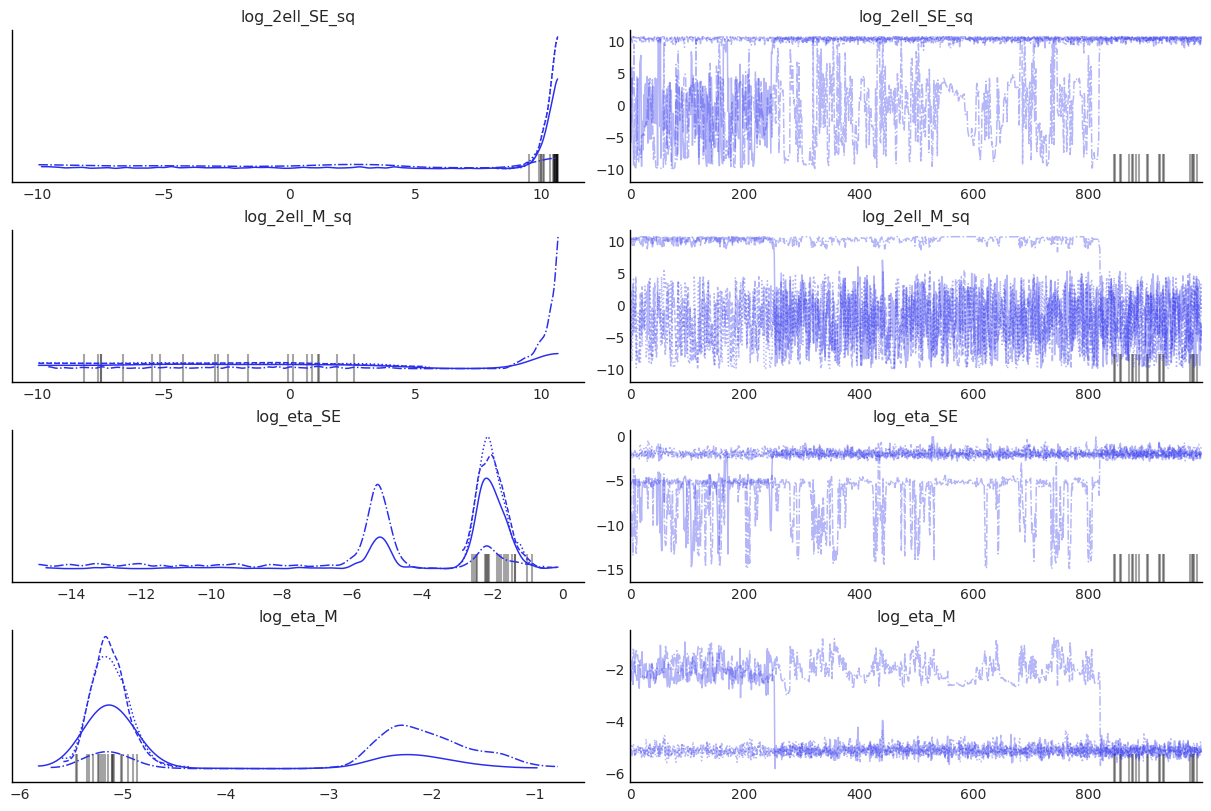

In [30]:
az.plot_trace(sem_gp_trace, var_names=variable_names, combined=False);

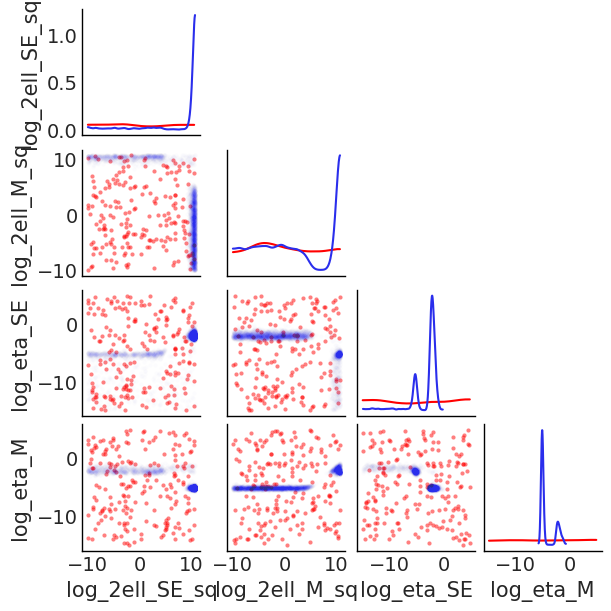

In [31]:
ax_list = az.plot_pair(
    sem_gp_trace, 
    group="prior", 
    var_names=variable_names,
    marginals=True, 
    figsize=(6,6), 
    kind=["scatter"],
    marginal_kwargs={"color":"red"},
    scatter_kwargs={"alpha":0.5, "color":"red"}
)

az.plot_pair(
    sem_gp_trace, 
    group="posterior",
    var_names=variable_names,
    marginals=True, 
    kind=["scatter"], 
    ax=ax_list, 
    scatter_kwargs={"alpha":0.01}
);

In [32]:
t_new = np.linspace(
    start=np.floor(t.min()), 
    stop=np.ceil(t.max()), 
    num = N_NEW
).reshape(-1,1)

with sem_gp_model:
    f_star = gp.conditional(name="f_star", Xnew=t_new, jitter=1e-6, pred_noise=False) 

In [33]:
with sem_gp_model:
    sem_gp_trace.extend(
        pm.sample_posterior_predictive(
            sem_gp_trace.posterior,  
            var_names=["f_star"], 
            random_seed=rng
        )
    )

Sampling: [f_star]


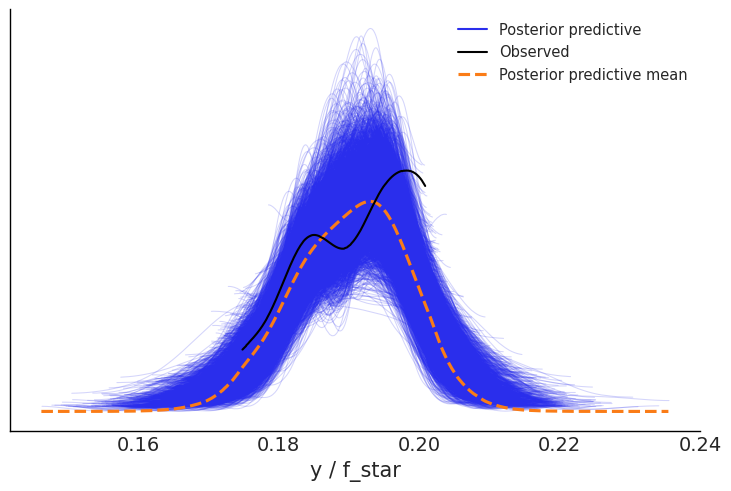

In [34]:
az.plot_ppc(sem_gp_trace, data_pairs={"y":"f_star"});

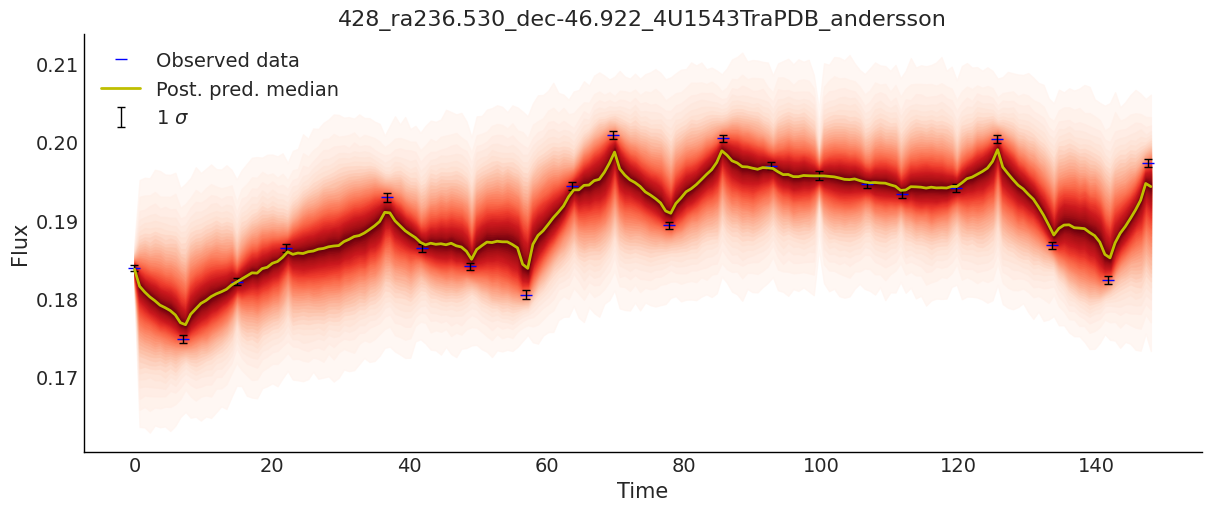

In [35]:
y_postpred = az.extract(sem_gp_trace.posterior_predictive, var_names=["f_star"])
y_postpred_median = y_postpred.median(dim="sample")

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plt.plot(t, y, "_b", ms=8, alpha=1, label="Observed data")
plt.errorbar(x=t, y=y, yerr=y_stderr, fmt="none", ecolor="k", elinewidth=1, capsize=3, label=r"1 $\sigma$")
plot_gp_dist(
    ax=ax, 
    samples=y_postpred.transpose("sample", ...),
    x=t_new,
    plot_samples=False
)
plt.plot(t_new.flatten(), y_postpred_median, "y", linewidth=2, label="Post. pred. median")
plt.title(f"{fpath.stem}")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend();

## SE GP + Matern $\frac{3}{2}$ GP

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{GP}(\boldsymbol{0}, k_\textrm{SE}(\tau)) + \mathcal{GP}(\boldsymbol{0}, k_\textrm{M}(\tau))$$

$$k_\textrm{SE}(\tau) = \eta^2_\textrm{SE}\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\}, \quad k_\textrm{M}(\tau) = \eta^2_\textrm{M}\left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{SE} \sim \mathcal{U}[-15, 5]$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta_\textrm{M} \sim \mathcal{U}[-15, 5]$$

$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

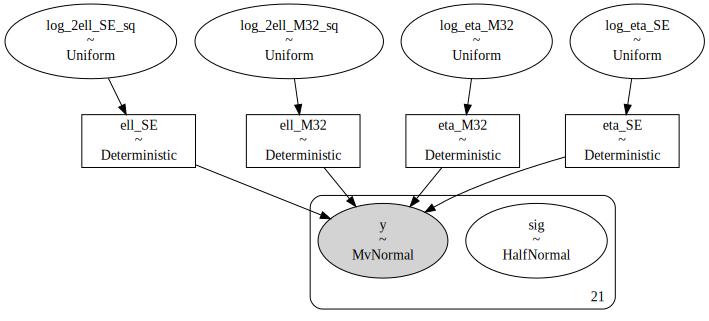

In [36]:
with pm.Model() as gp1_gp2_model:
    log_2ell_SE_sq = pm.Uniform("log_2ell_SE_sq", lower=-10, upper=math.log(2*t_range**2))
    ell_SE = pm.Deterministic("ell_SE", 0.5*math.sqrt(2) * pm.math.exp(0.5*log_2ell_SE_sq))
    log_eta_SE= pm.Uniform("log_eta_SE", lower=-15, upper=5)
    eta_SE = pm.Deterministic("eta_SE", pm.math.exp(log_eta_SE))

    cov_SE = eta_SE**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell_SE) 
    gp_SE = pm.gp.Marginal(cov_func=cov_SE) 

    log_2ell_M32_sq = pm.Uniform("log_2ell_M32_sq", lower=-10, upper=math.log(2*t_range**2))
    ell_M32 = pm.Deterministic("ell_M32", 0.5*math.sqrt(2) * pm.math.exp(0.5*log_2ell_M32_sq))
    log_eta_M32 = pm.Uniform("log_eta_M32", lower=-15, upper=5)
    eta_M32 = pm.Deterministic("eta_M32", pm.math.exp(log_eta_M32))

    cov_M32 = eta_M32**2 * pm.gp.cov.Matern32(input_dim=1, ls=ell_M32)
    gp_M32 = pm.gp.Marginal(cov_func=cov_M32)

    gp = gp_SE + gp_M32

    sig = pm.HalfNormal("sig", sigma=y_stderr) 
    cov_noise = pm.gp.cov.WhiteNoise(sigma=y_stderr)

    y_ = gp.marginal_likelihood(
        "y", 
        X=t.reshape(-1,1), 
        y=y.reshape(-1,1).flatten(), 
        sigma=cov_noise
    ) 

pm.model_to_graphviz(gp1_gp2_model)

Sampling: [log_2ell_M32_sq, log_2ell_SE_sq, log_eta_M32, log_eta_SE, sig, y]


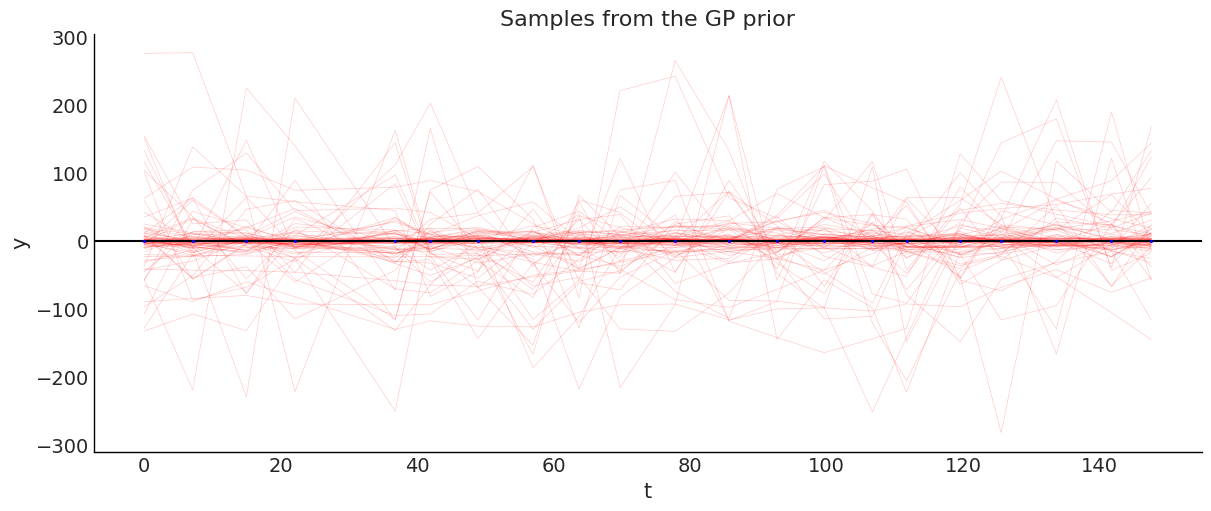

In [37]:
with gp1_gp2_model:
    gp1_gp2_trace = pm.sample_prior_predictive(samples=N_PPC, random_seed=rng)
    
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)

for prior_pred in gp1_gp2_trace.prior_predictive.y.to_numpy()[0]:
    ax.plot(t, prior_pred, lw=0.5, alpha=0.2, color="red")

ax.scatter(x=t, y=y, s=1.5, c="blue", zorder=10)
ax.axhline(0, color="black")
ax.set_title("Samples from the GP prior")
ax.set_ylabel("y")
ax.set_xlabel("t");

In [38]:
with gp1_gp2_model:
    gp1_gp2_trace.extend(
        pm.sample(
            draws=N_DRAWS, 
            tune=N_TUNE, 
            chains=4,
            cores=4, 
            random_seed=rng
        )       
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_2ell_SE_sq, log_eta_SE, log_2ell_M32_sq, log_eta_M32, sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [39]:
variable_names = ["log_2ell_SE_sq", "log_2ell_M32_sq", "log_eta_SE", "log_eta_M32"]
az.summary(gp1_gp2_trace, stat_focus="median", fmt="wide", var_names=variable_names, round_to="none", kind="all")

median       mad     eti_3%    eti_97%  mcse_median  \
log_2ell_SE_sq   10.296689  0.298812  -8.415392  10.668834     0.178763   
log_2ell_M32_sq  -0.675682  5.082898  -9.482641  10.603092     2.576340   
log_eta_SE       -2.194182  0.397758 -12.944719  -1.182595     0.179676   
log_eta_M32      -5.052976  0.203724  -5.448620  -1.430192     0.108574   

                 ess_median   ess_tail     r_hat  
log_2ell_SE_sq    13.043927  33.910406  1.461308  
log_2ell_M32_sq   11.779746  32.211538  1.526884  
log_eta_SE        12.665365  32.580398  1.484226  
log_eta_M32       11.723183  32.867693  1.528097

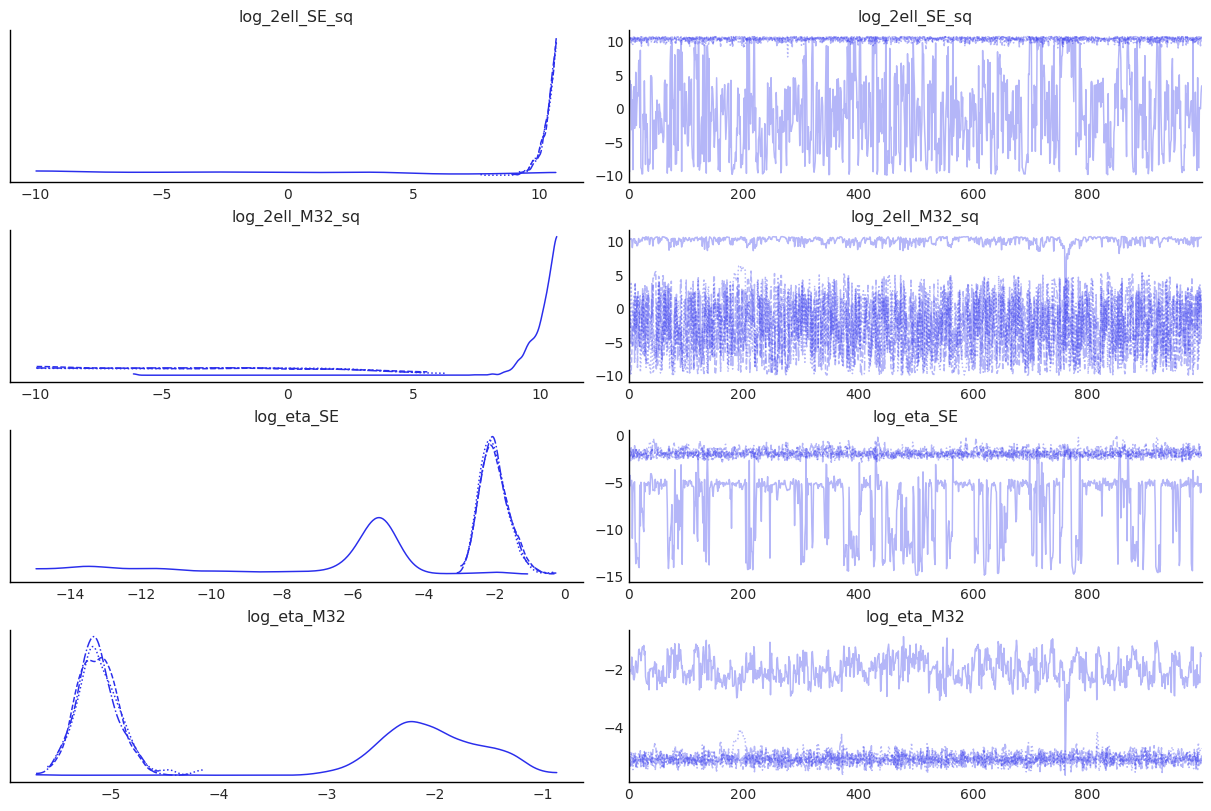

In [40]:
az.plot_trace(gp1_gp2_trace, var_names=variable_names, combined=False);

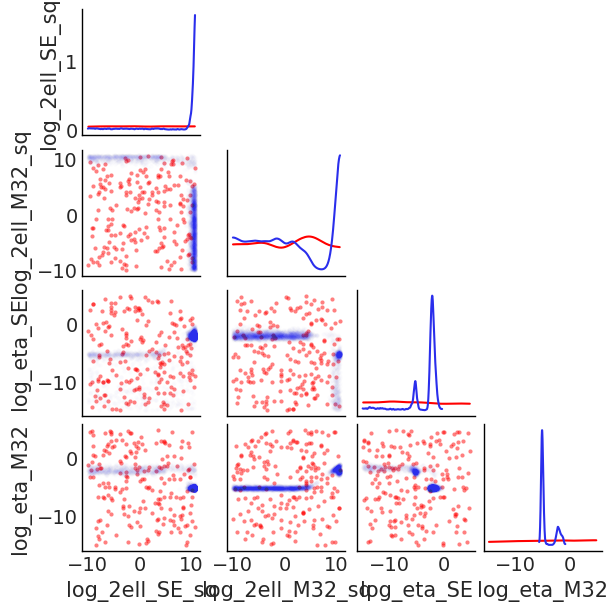

In [41]:
ax_list = az.plot_pair(
    gp1_gp2_trace, 
    group="prior", 
    var_names=variable_names,
    marginals=True, 
    figsize=(6,6), 
    kind=["scatter"],
    marginal_kwargs={"color":"red"},
    scatter_kwargs={"alpha":0.5, "color":"red"}
)

az.plot_pair(
    gp1_gp2_trace, 
    group="posterior",
    var_names=variable_names,
    marginals=True, 
    kind=["scatter"], 
    ax=ax_list, 
    scatter_kwargs={"alpha":0.01}
);

In [42]:
t_new = np.linspace(
    start=np.floor(t.min()), 
    stop=np.ceil(t.max()), 
    num = N_NEW
).reshape(-1,1)

with gp1_gp2_model:
    f_star = gp.conditional(name="f_star", Xnew=t_new, jitter=1e-6, pred_noise=False) 

In [43]:
with gp1_gp2_model:
    gp1_gp2_trace.extend(
        pm.sample_posterior_predictive(
            gp1_gp2_trace.posterior,  
            var_names=["f_star"], 
            random_seed=rng
        )
    )

Sampling: [f_star]


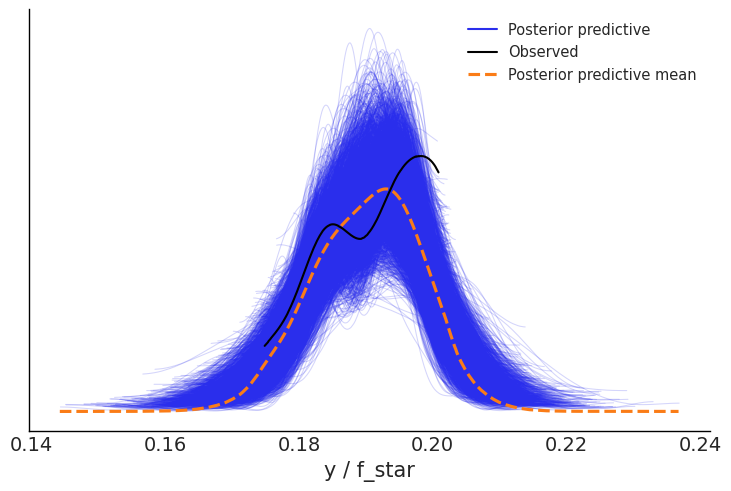

In [44]:
az.plot_ppc(gp1_gp2_trace, data_pairs={"y":"f_star"});

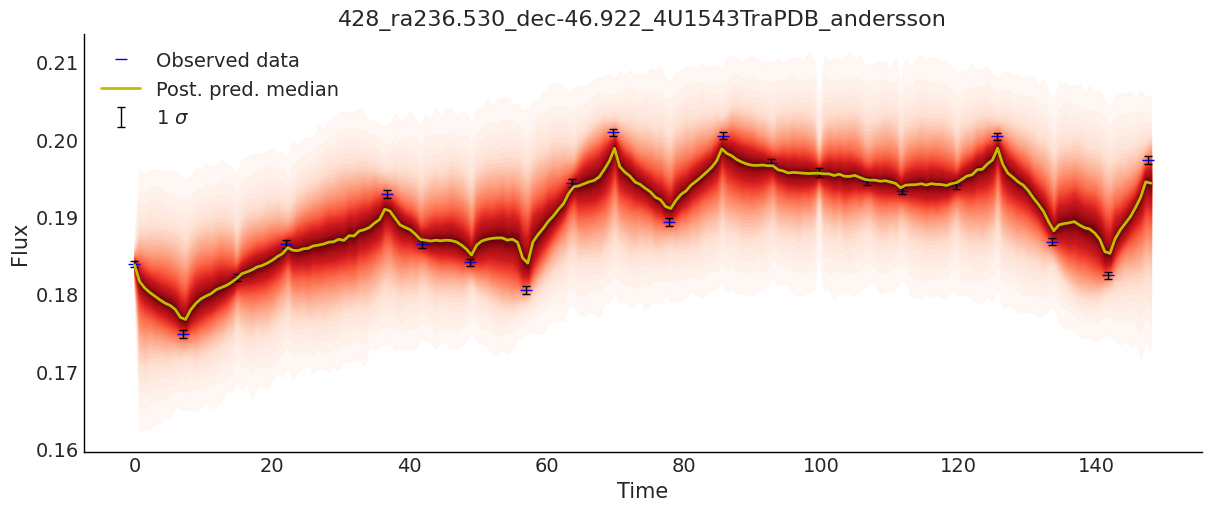

In [45]:
y_postpred = az.extract(gp1_gp2_trace.posterior_predictive, var_names=["f_star"])
y_postpred_median = y_postpred.median(dim="sample")

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plt.plot(t, y, "_b", ms=8, alpha=1, label="Observed data")
plt.errorbar(x=t, y=y, yerr=y_stderr, fmt="none", ecolor="k", elinewidth=1, capsize=3, label=r"1 $\sigma$")
plot_gp_dist(
    ax=ax, 
    samples=y_postpred.transpose("sample", ...),
    x=t_new,
    plot_samples=False
)
plt.plot(t_new.flatten(), y_postpred_median, "y", linewidth=2, label="Post. pred. median")
plt.title(f"{fpath.stem}")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend();

## SE $\times$ Matern $\frac{3}{2}$ Multiplicative Kernel

$$Y \sim \mathcal{N}(f(t), \sigma_\textrm{WN}^2)$$

$$f(t) \sim \mathcal{MVN}(\boldsymbol{0}, k_\mathrm{SE \times M}(\tau))$$

$$k_\mathrm{SE \times M}(\tau) = \eta^2\exp\left\{ - \frac{1}{2\ell_\textrm{SE}^2}\tau^2\right\} \left(1 + \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}}\right) \exp\left\{ - \frac{\sqrt{3\tau^2}}{\ell_\textrm{M}} \right\}$$

$$\log 2\ell^2_\textrm{SE} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log 2\ell^2_\textrm{M} \sim \mathcal{U}[-10, \log(2 \times (\textrm{t range})^2)]$$

$$\log \eta \sim \mathcal{U}[-15, 5]$$


$$\sigma_{\textrm{WN,i}} \sim \textrm{HalfNormal}(e_i^2)$$

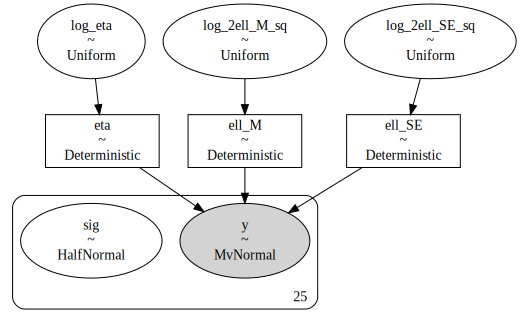

In [35]:
with pm.Model() as sexm_gp_model:
    log_2ell_SE_sq = pm.Uniform("log_2ell_SE_sq", lower=-10, upper=math.log(2*t_range**2))
    ell_SE = pm.Deterministic("ell_SE", 0.5*math.sqrt(2) * pm.math.exp(0.5*log_2ell_SE_sq))

    log_eta = pm.Uniform("log_eta", lower=-15, upper=5)
    eta = pm.Deterministic("eta", pm.math.exp(log_eta))

    log_2ell_M_sq = pm.Uniform("log_2ell_M_sq", lower=-10, upper=math.log(2*t_range**2))
    ell_M = pm.Deterministic("ell_M", 0.5*math.sqrt(2) * pm.math.exp(0.5*log_2ell_M_sq))

    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell_SE) * pm.gp.cov.Matern32(input_dim=1, ls=ell_M)
    
    gp = pm.gp.Marginal(cov_func=cov_func) # zero mean function 

    sig = pm.HalfNormal("sig", sigma=y_stderr) 
    cov_noise = pm.gp.cov.WhiteNoise(sigma=y_stderr)

    y_ = gp.marginal_likelihood(
        "y", 
        X=t.reshape(-1,1), 
        y=y.reshape(-1,1).flatten(), 
        sigma=cov_noise
    ) 

pm.model_to_graphviz(sexm_gp_model)

Sampling: [log_2ell_M_sq, log_2ell_SE_sq, log_eta, sig, y]


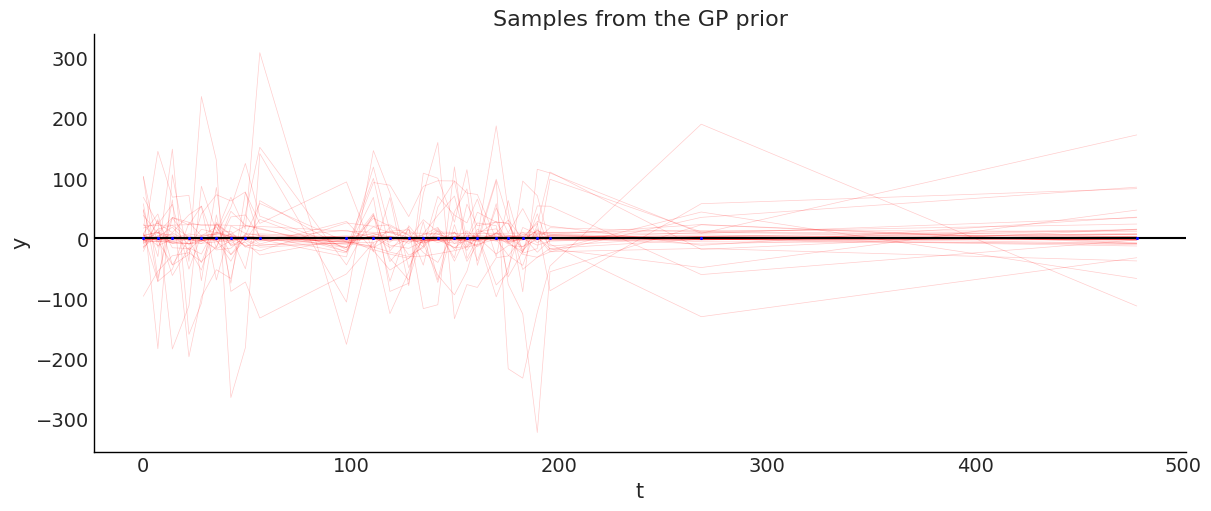

In [36]:
with sexm_gp_model:
    sexm_gp_trace = pm.sample_prior_predictive(samples=N_PPC, random_seed=rng)
    
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)

for prior_pred in sexm_gp_trace.prior_predictive.y.to_numpy()[0]:
    ax.plot(t, prior_pred, lw=0.5, alpha=0.2, color="red")

ax.scatter(x=t, y=y, s=1.5, c="blue", zorder=10)
ax.axhline(0, color="black")
ax.set_title("Samples from the GP prior")
ax.set_ylabel("y")
ax.set_xlabel("t");

In [37]:
with sexm_gp_model:
    sexm_gp_trace.extend(
        pm.sample(
            draws=N_DRAWS, 
            tune=N_TUNE, 
            chains=4,
            cores=4, 
            random_seed=rng
        )       
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_2ell_SE_sq, log_eta, log_2ell_M_sq, sig]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 250 seconds.


In [38]:
variable_names = ["log_2ell_SE_sq", "log_2ell_M_sq", "log_eta",]
az.summary(sexm_gp_trace, stat_focus="median", fmt="wide", var_names=variable_names, round_to="none", kind="all")

median       mad    eti_3%    eti_97%  mcse_median  \
log_2ell_SE_sq  11.868858  0.668057  9.689993  12.954360     0.021018   
log_2ell_M_sq   10.490448  0.432977  9.407523  12.095538     0.016130   
log_eta         -2.936063  0.237383 -3.463560  -1.922611     0.009395   

                 ess_median     ess_tail     r_hat  
log_2ell_SE_sq  2791.189115  2399.485902  1.001002  
log_2ell_M_sq   2875.573316   453.279734  1.007067  
log_eta         2227.655027   494.716733  1.006306

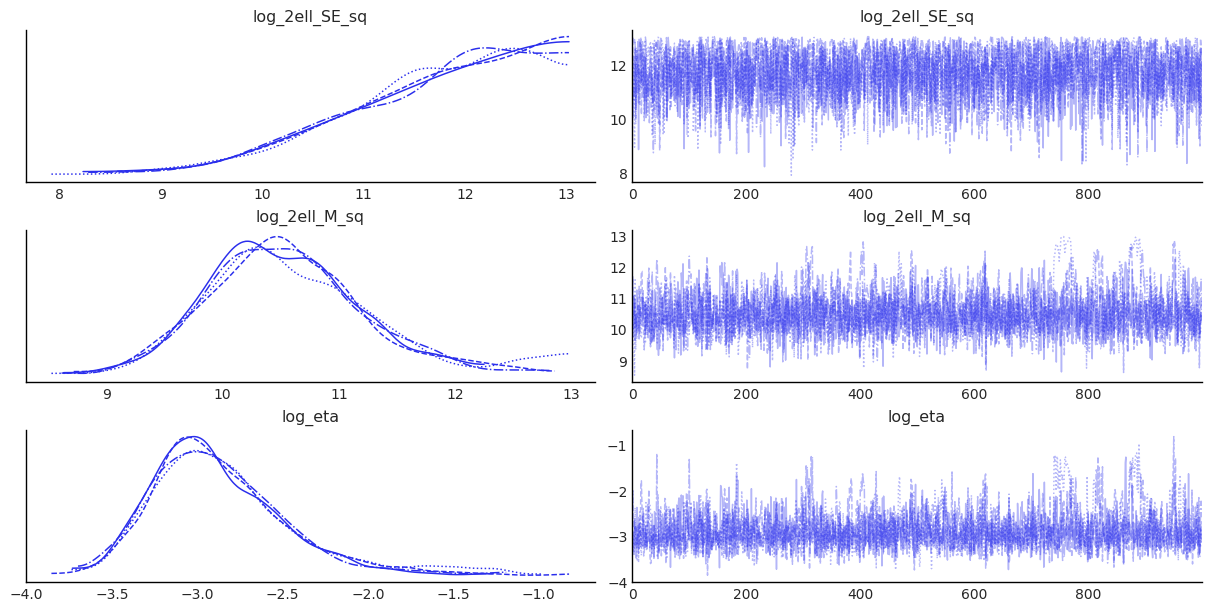

In [39]:
az.plot_trace(sexm_gp_trace, var_names=variable_names, combined=False);

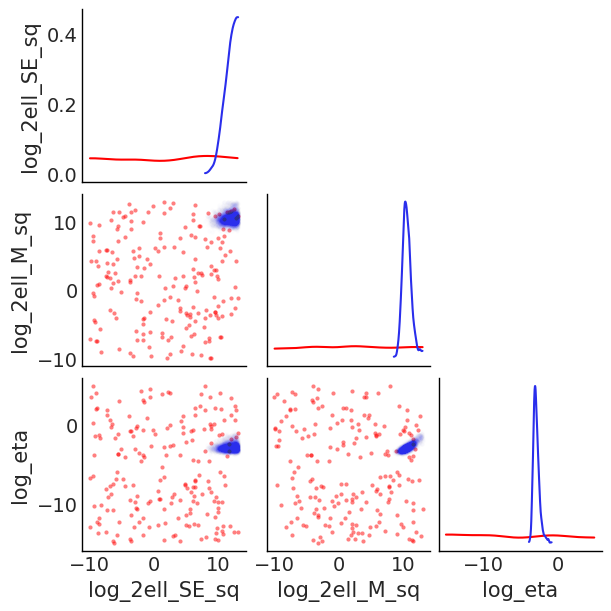

In [40]:
ax_list = az.plot_pair(
    sexm_gp_trace, 
    group="prior", 
    var_names=variable_names,
    marginals=True, 
    figsize=(6,6), 
    kind=["scatter"],
    marginal_kwargs={"color":"red"},
    scatter_kwargs={"alpha":0.5, "color":"red"}
)

az.plot_pair(
    sexm_gp_trace, 
    group="posterior",
    var_names=variable_names,
    marginals=True, 
    kind=["scatter"], 
    ax=ax_list, 
    scatter_kwargs={"alpha":0.01}
);

In [41]:
t_new = np.linspace(
    start=np.floor(t.min()), 
    stop=np.ceil(t.max()), 
    num = N_NEW
).reshape(-1,1)

with sexm_gp_model:
    f_star = gp.conditional(name="f_star", Xnew=t_new, jitter=1e-6, pred_noise=False) 

In [42]:
with sexm_gp_model:
    sexm_gp_trace.extend(
        pm.sample_posterior_predictive(
            sexm_gp_trace.posterior,  
            var_names=["f_star"], 
            random_seed=rng
        )
    )

Sampling: [f_star]


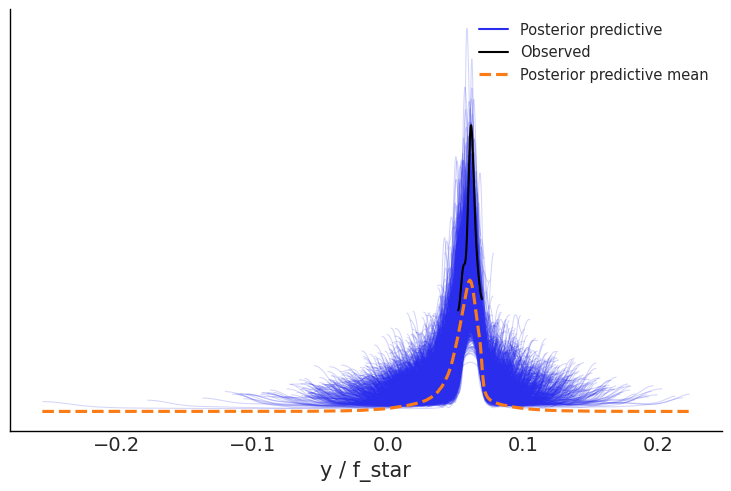

In [43]:
az.plot_ppc(sexm_gp_trace, data_pairs={"y":"f_star"});

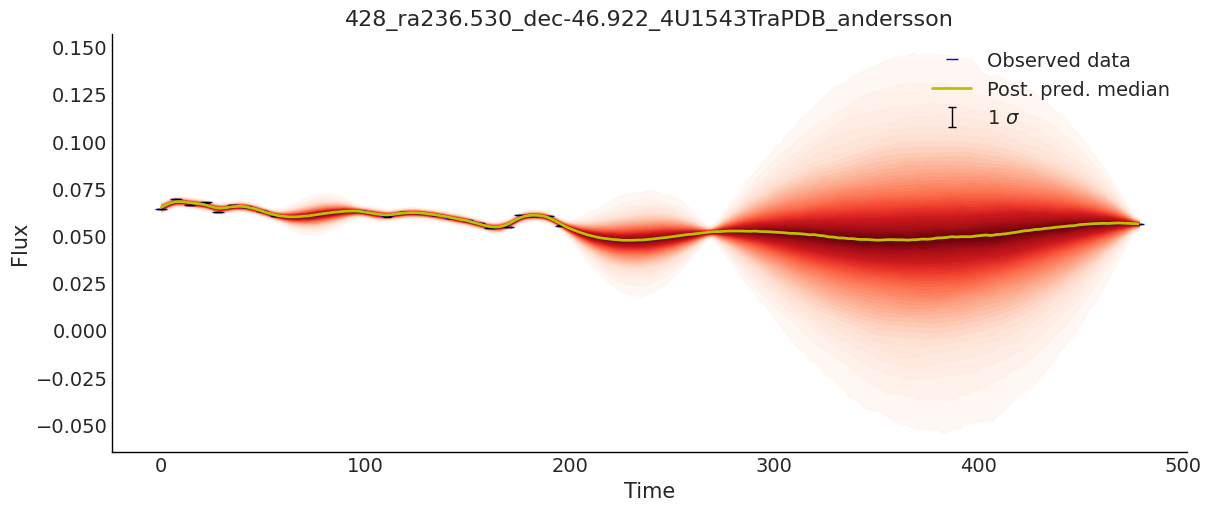

In [44]:
y_postpred = az.extract(sexm_gp_trace.posterior_predictive, var_names=["f_star"])
y_postpred_median = y_postpred.median(dim="sample")

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
plt.plot(t, y, "_b", ms=8, alpha=1, label="Observed data")
plt.errorbar(x=t, y=y, yerr=y_stderr, fmt="none", ecolor="k", elinewidth=1, capsize=3, label=r"1 $\sigma$")
plot_gp_dist(
    ax=ax, 
    samples=y_postpred.transpose("sample", ...),
    x=t_new,
    plot_samples=False
)
plt.plot(t_new.flatten(), y_postpred_median, "y", linewidth=2, label="Post. pred. median")
plt.title(f"{fpath.stem}")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend();

In [45]:
fpath

PosixPath('data_raw/428_ra236.530_dec-46.922_4U1543TraPDB_andersson.csv')